# Análisis de filtro PASA BANDA con RLC

Se tienen los datos de un experimento con el siguiente circuito,

```
 _____ -(SIN,f)+ _____ L _____ C _____ R _____   
|                  |               |          |  
GND               Vin             VR=Vout     GND
```

Parámetros:
- R = 1 $k \Omega$, 3 $k \Omega$ 
- L = 100 $mH$ (res. inter. $r_L= 100 \Omega$)
- C = 1 $n F$

- Frecuencia de resonancia aprox $\omega_0= \frac{1}{ \sqrt{L C} } \approx 15$ kHz
- $V_0$ sinusoidal, amplitud $5V$. Barrido en frecuencia  $f \in (3, 30)$ kHz 
- En $V_{in}$ se mide la amplitud de la señal de entrada (CRMS) respecto de GND (masa) (Res. int. gen. $r_G=50 \Omega$).
- En $V_{out}$ se mide la amplitud de la señal de salida (CRMS) en la resistencia respecto de GND (masa).

Empezamos importando las librerías necesarias,

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Cargo datos y hago un plot exploratorio,

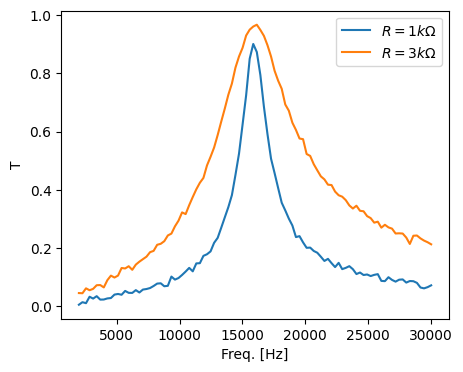

In [2]:
R1 = 1e3
R2 = 3e3
L = 100e-3
C = 1e-9

arx = 'datos/RLC_PBanda_R1k.csv'
df1 = pd.read_csv(arx)

arx = 'datos/RLC_PBanda_R3k.csv'
df2 = pd.read_csv(arx)

fig,ax = plt.subplots( figsize=(5,4))

ax.plot( df1["f"], df1["T"], label='$R= 1k \Omega $' )
ax.plot( df2["f"], df2["T"], label='$R= 3k \Omega $' )

ax.set_ylabel("T")
ax.set_xlabel("Freq. [Hz]")
ax.legend()
plt.show()

Vemos que la resistencia esta relacionada con el ancho de banda del filtro, mientras grande la resistencia más ancho el pico.

## Modelo

Calculamos la función de transferencia del filtro,

$$
V_{out} = V_{in} \frac{Z_R}{Z_R + Z_L + Z_C}
$$


$$
T = \frac{V_{out}}{V_{in}} = \frac{R}{R + j \omega L + \frac{1}{j \omega C} }
$$


$$
T = \frac{1}{1 + j  \frac{L}{R}  \big( \omega  - \frac{1}{ \omega L C} \big) }
= \frac{1}{1 + j  \frac{L}{R}  \big( \omega  - \frac{\omega_0^2}{ \omega } \big) }
$$


$$
T = \frac{1}{1 + j Q \big( \frac{\omega}{\omega_0}  - \frac{\omega_0}{ \omega } \big) }, 
\quad \omega_0 = \frac{1}{\sqrt{L C}}, \quad Q =  \omega_0 \frac{L}{R} 
$$

Donde $\omega_0$ es la frecuencia angular de resonancia del circuito RLC y $Q$ es el factor de mérito del filtro.

Poniendo las variables en términos de la frecuencia y tomando módulo obtenemos las expresiones a utilizar en el ajuste,


$$
f_0 = \frac{1}{2 \pi} \frac{1}{ \sqrt{LC} }
$$

$$
Q = \frac{ 2 \pi f_0  L}{R} 
$$


$$
|T| = \frac{1}{ \sqrt{ 1 + Q^2 \big( \frac{f}{f_0}  - \frac{f_0}{ f } \big)^2 } }
$$

Ajustamos el experimento con $R= 1k\Omega$,


In [3]:
def modelo_T( f, f0, Q ):
    x = f/f0
    T = 1.0/ np.sqrt( 1+ (Q*( x - 1.0/x ))**2 )
    return T


# tomamos los datos y cambiamos unidades de f para que los valores queden entre 0 y 1
U = 1e5
f1 = df1["f"].to_numpy()/U
T1 = df1["T"].to_numpy()

# Semilla frec corte
f0_ini = 0.1
Q_ini = 1
p0 = [f0_ini, Q_ini] 

# Ajuste
popt, pcov = curve_fit(modelo_T, f1, T1, p0=p0)      
f0_exp, Q_exp = popt

# Errores estandar
SE_f0, SE_Q = np.sqrt(np.diag(pcov))

print ("Parámetros obtenidos del ajuste:")
print(f"f0 = ({f0_exp:.6f} ± {SE_f0:.6f}) [UHz]")
print(f"Q = ({Q_exp:.3f} ± {SE_Q:.3f}) [Ohm]")


#calculo de valores teoricos
print ("\nValores teóricos:")
f0_th = (1.0/(2*np.pi))*(1/np.sqrt(L*C))/U
print(f"f0 res. teórica = {f0_th:.6f}  [UHz]")

Q_th = U*(2*np.pi*L*f0_th)/R1
print(f"Q fac. mer. teórico = {Q_th:.3f} ")


Parámetros obtenidos del ajuste:
f0 = (0.159249 ± 0.000133) [UHz]
Q = (10.337 ± 0.110) [Ohm]

Valores teóricos:
f0 res. teórica = 0.159155  [UHz]
Q fac. mer. teórico = 10.000 


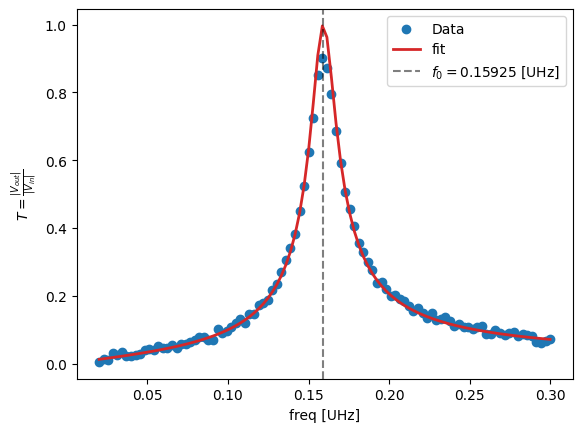

In [4]:
fig,ax = plt.subplots()

ax.scatter( f1,T1, label='Data' )

ax.plot(f1, modelo_T(f1, *popt), c= 'C3', label='fit', linewidth=2)

ax.axvline( f0_exp, linestyle='--', c='black', alpha=0.5, label=f'$f_0 = {f0_exp:.5f}$ [UHz]' )



ax.set_xlabel("freq [UHz]")
ax.set_ylabel(r"$T = \frac{|V_{out}|}{|V_{in}|}$")
ax.legend()
plt.show()

### Calculo de ancho de banda (BW) y frecuencias de corte inferior y superior

Para un circuito RLC en serie, el ancho de banda se define como la diferencia entre las frecuencias de corte superior ($f_S$) e inferior ($f_H$), las mismas se encuentran resolviendo,

$$
|T(f_c)| = \frac{1}{\sqrt{2}}
$$

de allí se desprende que, en un circuito RLC ideal, el ancho de banda viene dado por,

$$
BW = \frac{R}{2 \pi L}
$$


Las frecuencias de Corte Superior e Inferior ($f_H$ y $f_L$), calculadas de manera directa son,

$$
f_H = f_0 - \frac{BW}{2}, \quad f_H = f_0 + \frac{BW}{2}
$$



## Potencia activa

Es la potencia que se disipa en la carga $R$, la podemos expresar como,

$$
P_A = \frac{|V_{out}|^2}{R}.
$$

Esta curva es interesante por que esta relacionada directamente con el factor de mérito $Q$. Se puede probar que,

$$
Q = \frac{f_0}{ BWD } = \frac{f_0}{ f_2-f_1 }
$$

donde $BWD$ es el *ancho de banda* del filtro, y $f_{1,2}$ son las frecuencias que cortan la curva a $\frac{max(P_A)}{2}$,

Estimación del factor de mérito estimado a partir de la curva de potencia
Q estimado= 11.21


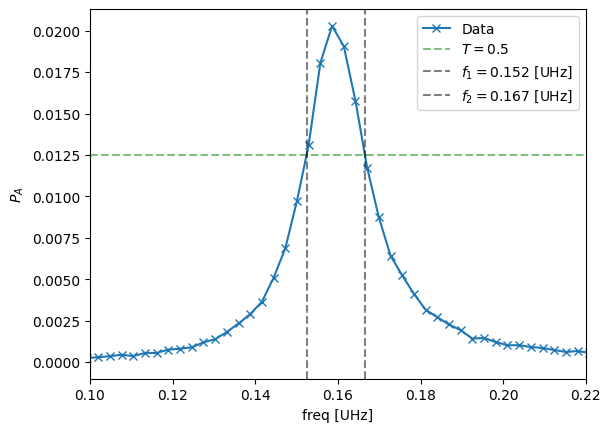

In [5]:
# calculamos la potencia
Vin = 5             # esta es la ampl. de la sinus. de entrada
Vout = T1*Vin
PA = Vout**2/R1
PA_max = (5**2)/R1  # potencia maxima

# plot
fig,ax = plt.subplots()

ax.plot( f1,PA, marker='x', label='Data' )

# marco el valor de la mitad de la potencia maxima
ax.axhline( 0.5*PA_max, linestyle='--', c='green', alpha=0.5, label=f'$T=0.5$' )

# ubico las frecuencias donde PA=PA_max/2 corta la curva
f1_ = 0.1524
f2_ = 0.1666

ax.axvline( f1_, linestyle='--', c='black', alpha=0.5, label=f'$f_1 = {f1_:.3f}$ [UHz]' )
ax.axvline( f2_, linestyle='--', c='black', alpha=0.5, label=f'$f_2 = {f2_:.3f}$ [UHz]' )

# factor de merito
Q_ = f0_exp/(f2_ - f1_)
print ("Estimación del factor de mérito estimado a partir de la curva de potencia")
print (f"Q estimado= {Q_:.2f}")

ax.set_xlabel("freq [UHz]")
ax.set_ylabel("$P_A$")
ax.set_xlim(0.10,0.22)
ax.legend()
plt.show()
